# Classifying handwritten digits

## Obtaining and preparing the MNIST dataset

The MNIST dataset is publicly available at http://yann.lecun.com/exdb/mnist/ and consists of the following four parts:

- Training set images: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, 60,000 examples)
- Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, 60,000 labels)
- Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, 10,000 examples)
- Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, 10,000 labels)



In [ ]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Normalize to [-1, 1] range:

In [ ]:
X = ((X / 255.) - .5) * 2

Visualize the first digit of each class:

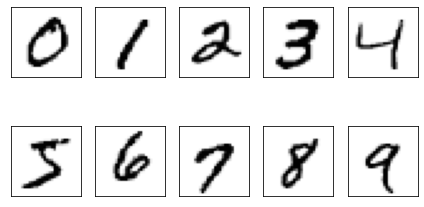

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
  img = X[y == i][0].reshape(28, 28)
  ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

Visualize 25 different versions of "7":

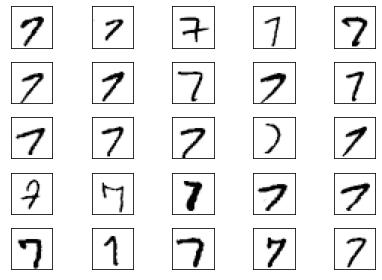

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
  img = X[y == 7][i].reshape(28, 28)
  ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

Split into training, validation, and test set:

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

<br>
<br>

## Implementing a multi-layer perceptron

In [ ]:
import numpy as np

In [ ]:
def sigmoid(z):                                        
  return 1. / (1. + np.exp(-z))

In [ ]:
def int_to_onehot(y, num_labels):
  ary = np.zeros((y.shape[0], num_labels))
  for i, val in enumerate(y):
    ary[i, val] = 1
  return ary

In [ ]:
##########################
### MODEL
##########################


class NeuralNetMLP:
  def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
    super().__init__()
    
    self.num_classes = num_classes
    
    # hidden
    rng = np.random.RandomState(random_seed)
    
    self.weight_h = rng.normal(
        loc=0.0, scale=0.1, size=(num_hidden, num_features))
    self.bias_h = np.zeros(num_hidden)
    
    # output
    self.weight_out = rng.normal(
        loc=0.0, scale=0.1, size=(num_classes, num_hidden))
    self.bias_out = np.zeros(num_classes)
      
  def forward(self, x):
    # Hidden layer
    # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
    # output dim: [n_examples, n_hidden]
    z_h = np.dot(x, self.weight_h.T) + self.bias_h
    a_h = sigmoid(z_h)

    # Output layer
    # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
    # output dim: [n_examples, n_classes]
    z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
    a_out = sigmoid(z_out)
    return a_h, a_out

  def backward(self, x, a_h, a_out, y):
    #########################
    ### Output layer weights
    #########################
    
    # onehot encoding
    y_onehot = int_to_onehot(y, self.num_classes)

    # Part 1: dLoss/dOutWeights
    ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
    ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
    ## for convenient re-use
    
    # input/output dim: [n_examples, n_classes]
    d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

    # input/output dim: [n_examples, n_classes]
    d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

    # output dim: [n_examples, n_classes]
    delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

    # gradient for output weights
    
    # [n_examples, n_hidden]
    d_z_out__dw_out = a_h
    
    # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
    # output dim: [n_classes, n_hidden]
    d_loss__d_w_out = np.dot(delta_out.T, d_z_out__dw_out)
    d_loss__d_b_out = np.sum(delta_out, axis=0)
    

    #################################        
    # Part 2: dLoss/dHiddenWeights
    ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
    
    # [n_classes, n_hidden]
    d_z_out__a_h = self.weight_out
    
    # output dim: [n_examples, n_hidden]
    d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
    
    # [n_examples, n_hidden]
    d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
    
    # [n_examples, n_features]
    d_z_h__d_w_h = x
    
    # output dim: [n_hidden, n_features]
    d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
    d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

    return (d_loss__d_w_out, d_loss__d_b_out, 
            d_loss__d_w_h, d_loss__d_b_h)

  def train_step(self, x, y, learning_rate):
    #### Compute outputs ####
    a_h, a_out = self.forward(x)

    #### Compute gradients ####
    (d_loss__d_w_out, d_loss__d_b_out,
     d_loss__d_w_h, d_loss__d_b_h) = \
        self.backward(x, a_h, a_out, y)

    #### Update weights ####
    self.weight_h -= learning_rate * d_loss__d_w_h
    self.bias_h -= learning_rate * d_loss__d_b_h
    self.weight_out -= learning_rate * d_loss__d_w_out
    self.bias_out -= learning_rate * d_loss__d_b_out

In [ ]:
##########################
### Multi HIDDEN Layer Perceptron
##########################


class NeuralNetMHLP:
  def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
    super().__init__()
    
    self.num_classes = num_classes

    rng = np.random.RandomState(random_seed)
    
    # hidden1
    self.weight_h_1 = rng.normal(
        loc=0.0, scale=0.1, size=(num_hidden, num_features))
    self.bias_h_1 = np.zeros(num_hidden)

    # hidden2
    self.weight_h_2 = rng.normal(
        loc=0.0, scale=0.1, size=(num_hidden, num_hidden))
    self.bias_h_2 = np.zeros(num_hidden)
    
    # output
    self.weight_out = rng.normal(
        loc=0.0, scale=0.1, size=(num_classes, num_hidden))
    self.bias_out = np.zeros(num_classes)
      
  def forward(self, x):
    # Hidden layer 1
    # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
    # output dim: [n_examples, n_hidden]
    z_h_1 = np.dot(x, self.weight_h_1.T) + self.bias_h_1
    a_h_1 = sigmoid(z_h_1)

    # Hidden layer 2
    # input dim: [n_examples, n_hidden] dot [n_hidden, n_hidden].T
    # output dim: [n_examples, n_hidden]
    z_h_2 = np.dot(a_h_1, self.weight_h_2.T) + self.bias_h_2
    a_h_2 = sigmoid(z_h_2)

    # Output layer
    # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
    # output dim: [n_examples, n_classes]
    z_out = np.dot(a_h_2, self.weight_out.T) + self.bias_out
    a_out = sigmoid(z_out)
    return a_h_1, a_h_2, a_out

  def backward(self, x, a_h_1, a_h_2, a_out, y):
    #########################
    ### Output layer weights
    #########################
    
    # onehot encoding
    y_onehot = int_to_onehot(y, self.num_classes)

    # Part 1: dLoss/dOutWeights
    ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
    ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
    ## for convenient re-use
    
    # input/output dim: [n_examples, n_classes]
    d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

    # input/output dim: [n_examples, n_classes]
    d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

    # output dim: [n_examples, n_classes]
    delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

    # gradient for output weights
    
    # [n_examples, n_hidden]
    d_z_out__dw_out = a_h_2
    
    # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
    # output dim: [n_classes, n_hidden]
    d_loss__d_w_out = np.dot(delta_out.T, d_z_out__dw_out)
    d_loss__d_b_out = np.sum(delta_out, axis=0)
    

    #################################        
    # Part 2: dLoss/dHiddenWeights2
    ## = DeltaOut * dOutNet/dHiddenAct2 * dHiddenAct2/dHiddenNet2 * dHiddenNet2/dHiddenWeights2
    ## where DeltaHidden2 = DeltaOut * dOutNet/dHiddenAct2 * dHiddenAct2/dHiddenNet2
    ## for convenient re-use
    
    # [n_classes, n_hidden]
    d_z_out__a_h_2 = self.weight_out
    
    # output dim: [n_examples, n_hidden]
    d_loss__a_h_2 = np.dot(delta_out, d_z_out__a_h_2)
    
    # [n_examples, n_hidden]
    d_a_h_2__d_z_h_2 = a_h_2 * (1. - a_h_2) # sigmoid derivative
    
    # [n_examples, n_features]
    d_z_h_2__d_w_h_2 = a_h_1

    delta_h_2 = d_loss__a_h_2 * d_a_h_2__d_z_h_2
    
    # output dim: [n_hidden, n_features]
    d_loss__d_w_h_2 = np.dot(delta_h_2.T, d_z_h_2__d_w_h_2)
    d_loss__d_b_h_2 = np.sum(delta_h_2, axis=0)


    #################################        
    # Part 3: dLoss/dHiddenWeights1
    ## = DeltaHidden2 * dHiddenNet2/dHiddenAct1 * dHiddenAct1/dHiddenNet1 * dHiddenNet1/dHiddenWeights1
    ## where DeltaHidden1 = DeltaHidden2 * dHiddenNet2/dHiddenAct1 * dHiddenAct1/dHiddenNet1
    ## for convenient re-use
    
    # [n_classes, n_hidden]
    d_z_h_2__a_h_1 = self.weight_h_2
    
    # output dim: [n_examples, n_hidden]
    d_loss__a_h_1 = np.dot(delta_h_2, d_z_h_2__a_h_1)
    
    # [n_examples, n_hidden]
    d_a_h_1__d_z_h_1 = a_h_1 * (1. - a_h_1) # sigmoid derivative
    
    # [n_examples, n_features]
    d_z_h_1__d_w_h_1 = x

    delta_h_1 = d_loss__a_h_1 * d_a_h_1__d_z_h_1
    
    # output dim: [n_hidden, n_features]
    d_loss__d_w_h_1 = np.dot(delta_h_1.T, d_z_h_1__d_w_h_1)
    d_loss__d_b_h_1 = np.sum(delta_h_1, axis=0)

    return (d_loss__d_w_out, d_loss__d_b_out, 
            d_loss__d_w_h_2, d_loss__d_b_h_2,
            d_loss__d_w_h_1, d_loss__d_b_h_1)
    
  def train_step(self, x, y, learning_rate):
    #### Compute outputs ####
    a_h_1, a_h_2, a_out = self.forward(x)

    #### Compute gradients ####
    (d_loss__d_w_out, d_loss__d_b_out,
     d_loss__d_w_h_2, d_loss__d_b_h_2,
     d_loss__d_w_h_1, d_loss__d_b_h_1) = \
        self.backward(x, a_h_1, a_h_2, a_out, y)

    #### Update weights ####
    self.weight_h_1 -= learning_rate * d_loss__d_w_h_1
    self.bias_h_1 -= learning_rate * d_loss__d_b_h_1
    self.weight_h_2 -= learning_rate * d_loss__d_w_h_2
    self.bias_h_2 -= learning_rate * d_loss__d_b_h_2
    self.weight_out -= learning_rate * d_loss__d_w_out
    self.bias_out -= learning_rate * d_loss__d_b_out

In [ ]:
num_features=28*28
num_hidden=50
num_classes=10

In [ ]:
model = NeuralNetMLP(num_features=num_features,
                     num_hidden=num_hidden,
                     num_classes=num_classes)
model2 = NeuralNetMHLP(num_features=num_features,
                       num_hidden=num_hidden,
                       num_classes=num_classes)

## Coding the neural network training loop

Defining data loaders:

In [ ]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
  indices = np.arange(X.shape[0])
  np.random.shuffle(indices)

  for start_idx in range(0,
                         indices.shape[0] - minibatch_size + 1,
                         minibatch_size):
    batch_idx = indices[start_idx:start_idx + minibatch_size]
    
    yield X[batch_idx], y[batch_idx]

        
# iterate over training epochs
for i in range(num_epochs):
  # iterate over minibatches
  minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
  for X_train_mini, y_train_mini in minibatch_gen:
    break
      
  break
    
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


Defining a function to compute the loss, accuracy, and AUC

In [ ]:
from sklearn.metrics import roc_auc_score

def compute_metrics(nnet, X, y, num_labels=10, minibatch_size=100):
  mse, correct_pred, num_examples, auc, auc_count = 0., 0, 0, 0, 0
  minibatch_gen = minibatch_generator(X, y, minibatch_size)
      
  for i, (features, targets) in enumerate(minibatch_gen):
    a = nnet.forward(features)
    probas = a[-1]
    predicted_labels = np.argmax(probas, axis=1)
    
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    loss = np.mean((onehot_targets - probas)**2)
    correct_pred += (predicted_labels == targets).sum()

    for label in range(num_labels):
      bin_targets = targets == label
      bin_predicted = predicted_labels == label
      if len(np.unique(bin_targets)) != 2:
        continue
      auc_count += 1
      auc += roc_auc_score(bin_targets, bin_predicted)
    
    num_examples += targets.shape[0]
    mse += loss

  mse /= i
  acc = correct_pred/num_examples
  auc /= auc_count
  return mse, acc, auc

In [ ]:
mse, acc, auc = compute_metrics(model, X_test, y_test)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')
print(f'Initial valid AUC: {auc*100:.1f}%')

Initial valid MSE: 0.0
Initial valid accuracy: 94.7%
Initial valid AUC: 97.0%


In [ ]:
mse, acc, auc = compute_metrics(model2, X_test, y_test)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')
print(f'Initial valid AUC: {auc*100:.1f}%')

Initial valid MSE: 0.0
Initial valid accuracy: 94.9%
Initial valid AUC: 97.1%


In [ ]:
def train(model, X_train, y_train, X_test, y_test, num_epochs,
          learning_rate=0.1):
  epoch_loss = []
  epoch_train_acc = []
  epoch_test_acc = []
  epoch_train_auc = []
  epoch_test_auc = []
  
  for e in range(num_epochs):
    # iterate over minibatches
    minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)

    for X_train_mini, y_train_mini in minibatch_gen:
      model.train_step(X_train_mini, y_train_mini, learning_rate)
    
    #### Epoch Logging ####        
    train_mse, train_acc, train_auc = compute_metrics(
        model, X_train, y_train)
    valid_mse, test_acc, test_auc = compute_metrics(
        model, X_test, y_test)
    train_acc, test_acc = train_acc*100, test_acc*100
    train_auc, test_auc = train_auc*100, test_auc*100
    epoch_train_acc.append(train_acc)
    epoch_test_acc.append(test_acc)
    epoch_train_auc.append(train_auc)
    epoch_test_auc.append(test_auc)
    epoch_loss.append(train_mse)
    print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
          f'| Train MSE: {train_mse:.2f} '
          f'| Train Acc: {train_acc:.2f}% '
          f'| Test Acc: {test_acc:.2f}% '
          f'| Train AUC: {train_auc:.2f}% '
          f'| Test AUC: {test_auc:.2f}%')

  return (epoch_loss,
          epoch_train_acc, epoch_test_acc,
          epoch_train_auc, epoch_test_auc)

In [ ]:
np.random.seed(123) # for the training set shuffling

(epoch_loss,
 epoch_train_acc, epoch_test_acc,
 epoch_train_auc, epoch_test_auc) = train(model,
                                          X_train, y_train,
                                          X_test, y_test,
                                          num_epochs=50,
                                          learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.05 | Train Acc: 74.28% | Test Acc: 73.93% | Train AUC: 85.38% | Test AUC: 85.47%
Epoch: 002/050 | Train MSE: 0.03 | Train Acc: 84.32% | Test Acc: 84.58% | Train AUC: 91.24% | Test AUC: 91.66%
Epoch: 003/050 | Train MSE: 0.03 | Train Acc: 87.43% | Test Acc: 87.59% | Train AUC: 93.09% | Test AUC: 93.38%
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 88.57% | Test Acc: 88.81% | Train AUC: 93.71% | Test AUC: 94.12%
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 89.76% | Test Acc: 90.03% | Train AUC: 94.43% | Test AUC: 94.84%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 90.24% | Test Acc: 90.49% | Train AUC: 94.65% | Test AUC: 95.14%
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 90.57% | Test Acc: 90.73% | Train AUC: 94.84% | Test AUC: 95.27%
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 91.05% | Test Acc: 91.20% | Train AUC: 95.17% | Test AUC: 95.55%
Epoch: 009/050 | Train MSE: 0.02 | Train Acc: 91.50% | Test Acc: 91.55% | Train AUC: 95.42% | Test AUC: 95.68%
E

In [ ]:
np.random.seed(123) # for the training set shuffling

(epoch_loss2,
 epoch_train_acc2, epoch_test_acc2,
 epoch_train_auc2, epoch_test_auc2) = train(model2,
                                            X_train, y_train,
                                            X_test, y_test,
                                            num_epochs=50,
                                            learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.09 | Train Acc: 21.68% | Test Acc: 21.82% | Train AUC: 56.00% | Test AUC: 56.25%
Epoch: 002/050 | Train MSE: 0.09 | Train Acc: 27.37% | Test Acc: 27.28% | Train AUC: 59.10% | Test AUC: 59.17%
Epoch: 003/050 | Train MSE: 0.08 | Train Acc: 35.40% | Test Acc: 35.30% | Train AUC: 63.49% | Test AUC: 63.67%
Epoch: 004/050 | Train MSE: 0.06 | Train Acc: 57.10% | Test Acc: 56.87% | Train AUC: 75.61% | Test AUC: 75.76%
Epoch: 005/050 | Train MSE: 0.05 | Train Acc: 70.03% | Test Acc: 69.78% | Train AUC: 82.93% | Test AUC: 83.13%
Epoch: 006/050 | Train MSE: 0.04 | Train Acc: 76.73% | Test Acc: 76.83% | Train AUC: 86.74% | Test AUC: 87.12%
Epoch: 007/050 | Train MSE: 0.03 | Train Acc: 83.22% | Test Acc: 83.40% | Train AUC: 90.47% | Test AUC: 91.01%
Epoch: 008/050 | Train MSE: 0.03 | Train Acc: 86.16% | Test Acc: 86.43% | Train AUC: 92.32% | Test AUC: 92.76%
Epoch: 009/050 | Train MSE: 0.02 | Train Acc: 87.55% | Test Acc: 87.90% | Train AUC: 93.17% | Test AUC: 93.60%
E

## Evaluating the neural network performance

In [ ]:
def plot_loss(epoch_loss):
  plt.plot(range(len(epoch_loss)), epoch_loss)
  plt.ylabel('Mean squared error')
  plt.xlabel('Epoch')
  plt.show()

In [ ]:
def plot_acc(epoch_train_acc, epoch_valid_acc):
  plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
          label='Training')
  plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
          label='Validation')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend(loc='lower right')
  plt.show()

In [ ]:
def plot_auc(epoch_train_auc, epoch_valid_auc):
  plt.plot(range(len(epoch_train_auc)), epoch_train_auc,
          label='Training')
  plt.plot(range(len(epoch_valid_auc)), epoch_valid_auc,
          label='Validation')
  plt.ylabel('AUC')
  plt.xlabel('Epochs')
  plt.legend(loc='lower right')
  plt.show()

In [ ]:
def plot_training(epoch_loss,
                  epoch_train_acc, epoch_test_acc,
                  epoch_train_auc, epoch_test_auc):
  plot_loss(epoch_loss)
  plot_acc(epoch_train_acc, epoch_test_acc)
  plot_auc(epoch_train_auc, epoch_test_auc)

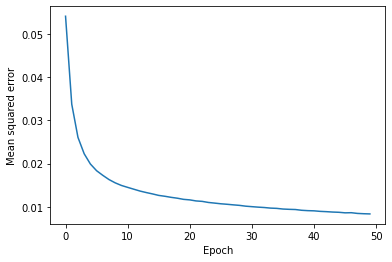

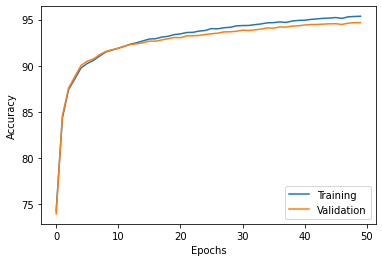

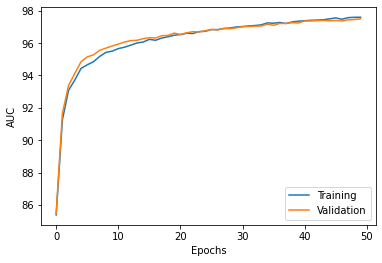

In [ ]:
plot_training(epoch_loss,
              epoch_train_acc, epoch_test_acc,
              epoch_train_auc, epoch_test_auc)

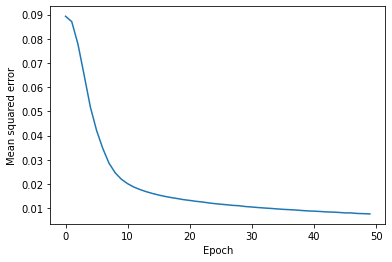

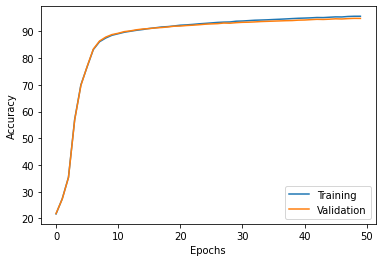

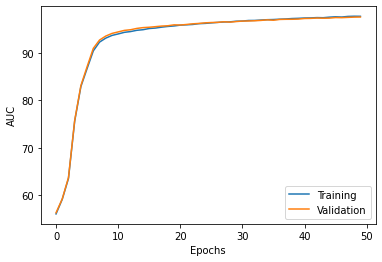

In [ ]:
plot_training(epoch_loss2,
              epoch_train_acc2, epoch_test_acc2,
              epoch_train_auc2, epoch_test_auc2)

In [ ]:
test_mse, test_acc, test_auc = compute_metrics(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')
print(f'Test AUC: {test_auc*100:.2f}%')

Test accuracy: 94.67%
Test AUC: 97.49%


In [ ]:
test_mse, test_acc, test_auc = compute_metrics(model2, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')
print(f'Test AUC: {test_auc*100:.2f}%')

Test accuracy: 94.90%
Test AUC: 97.62%


Plot failure cases:

In [ ]:
def plot_failures(model, X_test, y_test, subset_size, nrows, ncols):
  ndisplay = nrows * ncols

  X_test_subset = X_test[:subset_size, :]
  y_test_subset = y_test[:subset_size]

  a = model.forward(X_test_subset)
  probas = a[-1]
  test_pred = np.argmax(probas, axis=1)

  misclassified_images = X_test_subset[y_test_subset != test_pred][:ndisplay]
  misclassified_labels = test_pred[y_test_subset != test_pred][:ndisplay]
  correct_labels = y_test_subset[y_test_subset != test_pred][:ndisplay]

  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, 
                        sharex=True, sharey=True, figsize=(8, 8))
  ax = ax.flatten()
  for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

  ax[0].set_xticks([])
  ax[0].set_yticks([])
  plt.tight_layout()
  plt.show()

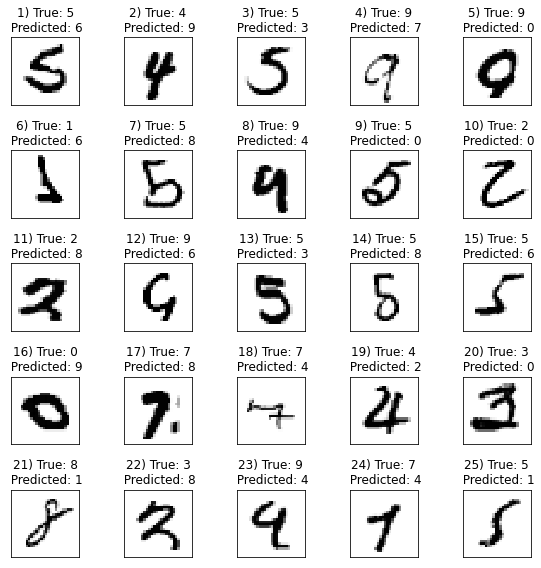

In [ ]:
plot_failures(model, X_test, y_test, 1000, 5, 5)

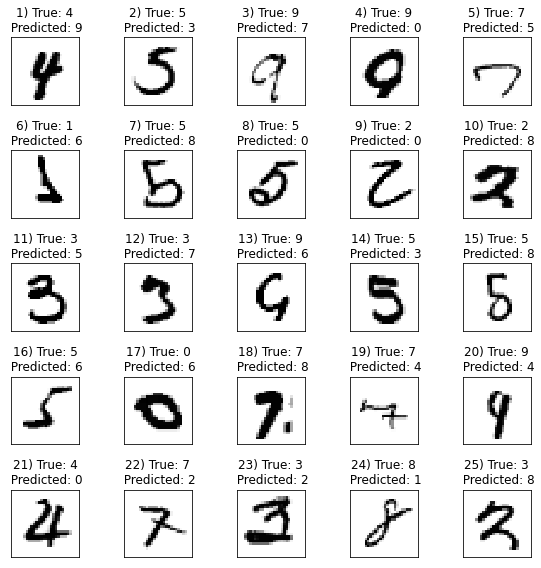

In [ ]:
plot_failures(model2, X_test, y_test, 1000, 5, 5)

## PyTorch

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class TorchNetwork(nn.Module):
  def __init__(self, num_features, num_hidden, num_classes):
    super(TorchNetwork, self).__init__()
    self.fc1 = nn.Linear(num_features, num_hidden)
    self.fc2 = nn.Linear(num_hidden, num_hidden)
    self.fc3 = nn.Linear(num_hidden, num_classes)

  def forward(self, x):
    x = torch.sigmoid(self.fc1(x))
    x = torch.sigmoid(self.fc2(x))
    x = torch.sigmoid(self.fc3(x))
    return x

model_torch = TorchNetwork(num_features=num_features,
                           num_hidden=num_hidden,
                           num_classes=num_classes)
model_torch = model_torch.to(device)

In [ ]:
def numpy_to_dataloader(X, y, batch_size):
  X = torch.Tensor(X)
  y = torch.Tensor(y)
  y = y.long()
  y = F.one_hot(y, num_classes=num_classes)
  y = y.float()
  dataset = TensorDataset(X, y)
  dataloader = DataLoader(dataset, batch_size=batch_size)
  return dataloader

In [ ]:
def pytorch_calculate_loss(model, criterion, data, labels):
  target = model(data)
  loss = criterion(target, labels)
  return loss

In [ ]:
def pytorch_compute_metrics(model, criterion, loader):
  model.eval()
  running_loss = 0
  correct = 0
  total = 0
  auc = 0
  auc_count = 0
  with torch.no_grad():
    for data, labels in loader:
      data = data.to(device)
      labels = labels.to(device)

      outputs = model(data)

      loss = criterion(outputs, labels)
      running_loss += loss.item()

      _, predicted = outputs.max(1)
      _, real = labels.max(1)
      total += labels.size(0)
      correct += predicted.eq(real).sum().item()

      aucs = []
      for label in range(10):
        bin_predicted = predicted == label
        bin_predicted = bin_predicted.cpu().numpy()
        bin_real = real == label
        bin_real = bin_real.cpu().numpy()
        if len(np.unique(bin_real)) != 2:
          continue
        auc_count += 1
        aucs.append(roc_auc_score(bin_real, bin_predicted))
      auc += sum(aucs)
  avg_loss = running_loss / len(loader)
  acc = 100 * correct / total
  auc = 100 * auc / auc_count
  return avg_loss, acc, auc

In [ ]:
def torch_train(model,
                criterion, optimizer_fn,
                X_train, y_train, X_test, y_test,
                num_epochs, learning_rate=0.1):
  optimizer = optimizer_fn(model_torch.parameters(), lr=learning_rate)
  
  trainloader = numpy_to_dataloader(X_train, y_train, minibatch_size)
  testloader = numpy_to_dataloader(X_test, y_test, minibatch_size)

  epoch_loss = []
  epoch_train_acc = []
  epoch_test_acc = []
  epoch_train_auc = []
  epoch_test_auc = []
 
  for e in range(num_epochs):
    model.train()
    for data, labels in trainloader:
      data = data.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      loss = pytorch_calculate_loss(model, criterion, data, labels)
      loss.backward()
      optimizer.step()
    
    train_mse, train_acc, train_auc = pytorch_compute_metrics(
        model, criterion, trainloader)
    test_mse, test_acc, test_auc = pytorch_compute_metrics(
        model, criterion, testloader)
    epoch_train_acc.append(train_acc)
    epoch_test_acc.append(test_acc)
    epoch_train_auc.append(train_auc)
    epoch_test_auc.append(test_auc)
    epoch_loss.append(train_mse)
    print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
          f'| Train MSE: {train_mse:.2f} '
          f'| Train Acc: {train_acc:.2f}% '
          f'| Test Acc: {test_acc:.2f}%'
          f'| Train AUC: {train_auc:.2f}% '
          f'| Test AUC: {test_auc:.2f}%')

  return (epoch_loss,
          epoch_train_acc, epoch_test_acc,
          epoch_train_auc, epoch_test_auc)

In [ ]:
criterion = nn.MSELoss()
def sgd_optim_fn(parameters, lr):
  return torch.optim.SGD(parameters, lr=lr)

In [ ]:
(epoch_loss_t,
 epoch_train_acc_t, epoch_test_acc_t,
 epoch_train_auc_t, epoch_test_auc_t) = torch_train(
    model_torch,
    criterion, sgd_optim_fn,
    X_train, y_train, X_test, y_test,
    50)

Epoch: 001/050 | Train MSE: 0.09 | Train Acc: 11.12% | Test Acc: 11.56%| Train AUC: 50.00% | Test AUC: 50.00%
Epoch: 002/050 | Train MSE: 0.09 | Train Acc: 11.12% | Test Acc: 11.56%| Train AUC: 50.00% | Test AUC: 50.00%
Epoch: 003/050 | Train MSE: 0.09 | Train Acc: 11.12% | Test Acc: 11.56%| Train AUC: 50.00% | Test AUC: 50.00%
Epoch: 004/050 | Train MSE: 0.09 | Train Acc: 11.12% | Test Acc: 11.56%| Train AUC: 50.00% | Test AUC: 50.00%
Epoch: 005/050 | Train MSE: 0.09 | Train Acc: 11.12% | Test Acc: 11.56%| Train AUC: 50.00% | Test AUC: 50.00%
Epoch: 006/050 | Train MSE: 0.09 | Train Acc: 11.12% | Test Acc: 11.56%| Train AUC: 50.00% | Test AUC: 50.00%
Epoch: 007/050 | Train MSE: 0.09 | Train Acc: 11.12% | Test Acc: 11.56%| Train AUC: 50.00% | Test AUC: 50.00%
Epoch: 008/050 | Train MSE: 0.09 | Train Acc: 11.13% | Test Acc: 11.57%| Train AUC: 50.01% | Test AUC: 50.01%
Epoch: 009/050 | Train MSE: 0.09 | Train Acc: 11.37% | Test Acc: 11.96%| Train AUC: 50.14% | Test AUC: 50.22%
Epoch: 010

## Model Comparison

In [ ]:
def compare_metrics(metrics, metric_name):
  for name, metric in metrics.items():
    plt.plot(range(len(metric)), metric, label=name)
  plt.ylabel(metric_name)
  plt.xlabel('Epochs')
  plt.legend()
  plt.show()

### Loss

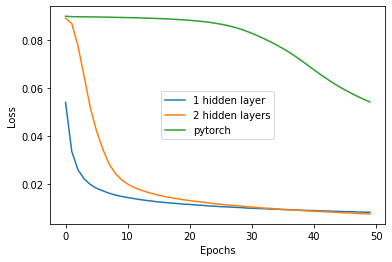

In [ ]:
compare_metrics({
    '1 hidden layer': epoch_loss,
    '2 hidden layers': epoch_loss2,
    'pytorch': epoch_loss_t,
    },
    'Loss')

### Accuracy

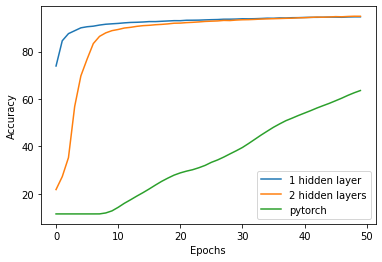

In [ ]:
compare_metrics({
    '1 hidden layer': epoch_test_acc,
    '2 hidden layers': epoch_test_acc2,
    'pytorch': epoch_test_acc_t,
    },
    'Accuracy')

### AUC

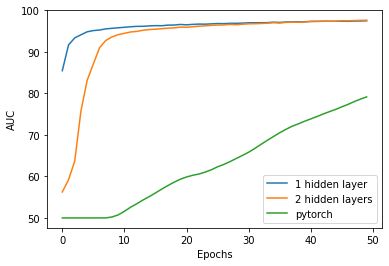

In [ ]:
compare_metrics({
    '1 hidden layer': epoch_test_auc,
    '2 hidden layers': epoch_test_auc2,
    'pytorch': epoch_test_auc_t,
    },
    'AUC')